In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(500)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
os.listdir(path)

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [4]:
train_df = pl.read_parquet(path + 'train.parquet/').select(pl.all().shrink_dtype())
y_sr = train_df['responder_6']
train_df = train_df.drop(['partition_id']).select(pl.all().shrink_dtype())
print(train_df.shape)
train_df.head()

(47127338, 92)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,

In [5]:
train_df.estimated_size() / 1e9

16.790916418

In [6]:
# https://www.kaggle.com/code/motono0223/js24-preprocessing-create-lags/notebook

class CONFIG:
    target_col = "responder_6"
    lag_cols_original = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]
    lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}
    valid_ratio = 0.05
    start_dt = 1100

In [7]:
lags = train_df.select(pl.col(CONFIG.lag_cols_original))
lags = lags.rename(CONFIG.lag_cols_rename)
lags = lags.with_columns(
    date_id = pl.col('date_id') + 1,  # lagged by 1 day
    )
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()  # pick up last record of previous date
print(lags.shape)
lags.head()

(50382, 11)


date_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,1,1.382971,0.416069,3.134381,1.032238,0.580303,1.853194,0.01209,0.040493,0.013765
1,7,0.635954,0.173196,3.124839,1.068124,0.436262,1.311089,0.116055,0.073651,0.164904
1,9,0.248801,-0.104118,-0.110137,0.168204,0.112685,0.459633,0.041742,0.04499,0.063626
1,10,-1.626361,-0.753249,-0.433064,-1.753868,-0.806781,-2.706254,-0.455618,-0.197604,-0.864137
1,14,5.0,3.496727,5.0,4.731386,2.209459,5.0,0.36648,0.315538,0.699698


In [8]:
train_df = train_df.join(lags, on=["date_id", "symbol_id"],  how="left").drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8']).select(pl.all().shrink_dtype())
print(train_df.shape)
train_df.head()

(47127338, 92)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,null,null,null,null,null,null,null,null,null
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,null,null,null,null,null,null,null,null,null
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,null,null,null,null,null,null,null,null,null
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,null,null,null,null,null,null,null

In [9]:
lags_df = pl.read_parquet(path + 'lags.parquet/').select(pl.all().shrink_dtype())
print(lags_df.shape)
lags_df

(39, 12)


date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i8,i8,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,0,-0.442215,-0.322407,0.143594,-0.92689,-0.782236,-0.036595,-1.305746,-0.795677,-0.143724
0,0,1,-0.651829,-1.70784,-0.893942,-1.065488,-1.871338,-0.615652,-1.162801,-1.205924,-1.245934
0,0,2,-0.656373,-0.264575,-0.892879,-1.511886,-1.03348,-0.378265,-1.57429,-1.863071,-0.027343
0,0,3,-0.188186,-0.19097,-0.70149,0.098453,-1.015506,-0.054984,0.329152,-0.965471,0.576635
0,0,4,-0.257462,-0.471325,-0.29742,0.074018,-0.324194,-0.597093,0.219856,-0.276356,-0.90479
0,0,5,0.027579,-0.020169,0.640348,-0.948373,-0.374251,-0.24035,-0.913801,-0.548867,-1.283726
0,0,6,-0.419646,-0.181228,-0.194079,0.667993,0.936857,0.517728,0.896325,1.068884,1.57929
0,0,7,-0.114118,-0.198511,-0.200027,-0.410021,-0.135167,-0.182887,-0.492168,-0.142915,-0.202081
0,0,8,-0.374147,0.092127,0.294723,0.402989,2.060188,-0.225042,0.95646,2.185598,-0.435856


In [10]:
def lgb_train(train_data, y):
    weights = train_data['weight']
    
    unique_date_ids = train_data['date_id'].unique()
    train_date_id_cut = int(unique_date_ids.max() * 0.85)
    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)
    
    X_train = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])
    
    y_train = y[:X_train.shape[0]].to_pandas()
    y_val = y[X_train.shape[0]:].to_pandas()
    
    weights_train = weights[:X_train.shape[0]].to_pandas()
    weights_val = weights[X_train.shape[0]:].to_pandas()

    print(X_train.shape)
    display(X_train.head())

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.03,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100
    }
    
    model = LGBMRegressor(
        **base_params,
        n_estimators=100000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=50)])#, categorical_feature=['feature_09', 'feature_10', 'feature_11'])

    val_preds = model.predict(X_val)

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 1)
    plt.show()

    models_path = path + 'my_folder/models/20241229_03/'

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    with open(models_path + "lgb_model.pkl", 'wb') as file:
        pickle.dump(model, file)

    print('Val R2 score is:', r2_score(y_val, val_preds))
    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    sample_val = X_val.sample(frac=0.001)
    sample_y = y_val.loc[sample_val.index]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X=sample_val, y=sample_y)
    shap_importance = np.abs(shap_values).mean(axis=0)

    return shap_importance

max date: 1698
date id cut: 1443
0.8005145972810941
(37726122, 88)


,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,NaN,0.317467,NaN,-1.250016,-1.682929,1.412757,NaN,0.520378,0.744132,-0.788658,0.641776,NaN,NaN,0.227200,0.580907,1.128879,NaN,NaN,NaN,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835207,-0.002704,-0.621836,NaN,1.172836,NaN,NaN,-1.625862,NaN,-1.410017,1.063013,NaN,0.888355,0.467994,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,0.249901,-0.773050,11,7,76,-0.675719,-0.199404,-0.586798,NaN,-0.814909,NaN,-1.296782,-2.040234,0.639589,NaN,1.597359,0.657514,-1.350148,0.364215,NaN,NaN,-0.017751,-0.317361,-0.122379,NaN,NaN,NaN,-0.320921,-0.958090,-2.436589,0.070999,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420632,-3.515137,-4.677760,NaN,0.535897,NaN,NaN,-0.725420,NaN,-2.294170,1.764551,NaN,-0.120789,-0.063458,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,NaN,-0.251882,NaN,-1.902009,-0.979447,0.241165,NaN,-0.392359,-0.224699,-2.129397,-0.855287,NaN,NaN,0.404142,-0.578156,0.105702,NaN,NaN,NaN,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382074,2.669135,0.611711,NaN,2.413415,NaN,NaN,1.313203,NaN,-0.810125,2.939022,NaN,3.988801,1.834661,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,NaN,0.646086,NaN,-1.844685,-1.586560,-0.182024,NaN,-0.969949,-0.673813,-1.282132,-1.399894,NaN,NaN,0.043815,-0.320225,-0.031713,NaN,NaN,NaN,-0.088420,-0.995003,-2.635336,-0.196461,-0.618719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.014600,-2.321076,-3.711265,NaN,1.253902,NaN,NaN,0.476195,NaN,-0.771732,2.843421,NaN,1.379815,0.411827,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,NaN,NaN,3.678076,2.793581,2.618250,3.418133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[50]	training's l2: 0.751547	valid_1's l2: 0.608322
[100]	training's l2: 0.748844	valid_1's l2: 0.606684
[150]	training's l2: 0.747055	valid_1's l2: 0.605868
[200]	training's l2: 0.745659	valid_1's l2: 0.605375
[250]	training's l2: 0.744275	valid_1's l2: 0.604982
[300]	training's l2: 0.742928	valid_1's l2: 0.604795
[350]	training's l2: 0.741905	valid_1's l2: 0.604599
[400]	training's l2: 0.740944	valid_1's l2: 0.604414
[450]	training's l2: 0.74009	valid_1's l2: 0.60428
[500]	training's l2: 0.739267	valid_1's l2: 0.604203
[550]	training's l2: 0.738416	valid_1's l2: 0.604123
[600]	training's l2: 0.737668	valid_1's l2: 0.60403
[650]	training's l2: 0.736981	valid_1's l2: 0.603944
[700]	training's l2: 0.736283	valid_1's l2: 0.60393


<Figure size 640x480 with 0 Axes>

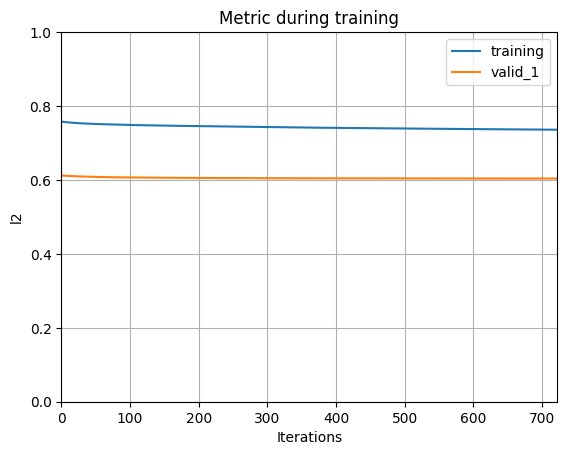

Val R2 score is: 0.0127940038274994
Val Weighted R2 score is: 0.013671164096467847


In [11]:
first_shap_importance = lgb_train(train_df, y_sr)

In [ ]:
cols = train_df.drop(['date_id', 'time_id', 'symbol_id']).columns
imp_df = pd.DataFrame(sorted(zip(cols, first_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [ ]:
print(imp_df.shape)

In [ ]:
imp_df

In [ ]:
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.3)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df = train_df.drop(unimportant_cols)
print(train_selected_df.shape)
train_selected_df.head()

In [ ]:
second_shap_importance = lgb_train(train_selected_df, y_sr)